## Imports

In [1]:
import torch
from torchvision import models
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from dataset import MultitaskDataset


## Set the checkpoint path

In [ ]:
CHECKPOINT_PATH = './best_resnet152_fold10.pth'

## Helper Functions

In [2]:
# Function to load ResNet-152 model
def load_resnet152(checkpoint_path):
    # Load the pretrained ResNet-152 model
    model = models.resnet152(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 1) 

    # Load the saved model weights
    model.load_state_dict(torch.load(checkpoint_path))

    # Set model to evaluation mode
    model.eval()
    
    return model

# Function to extract the CAM
def generate_cam(model, image_tensor, target_layer='layer4'):
    # Hook to capture the output of the last convolutional layer
    def forward_hook(module, input, output):
        global conv_output
        conv_output = output

    # Attach hook to the specified layer (e.g., layer4)
    layer = dict(model.named_modules())[target_layer]
    hook = layer.register_forward_hook(forward_hook)

    # Perform forward pass to compute the output
    with torch.no_grad():
        output = model(image_tensor)

    # Remove hook
    hook.remove()

    # Get the gradients and the convolution output
    global conv_output

    # Compute the weight for each channel in the feature map
    weights = torch.mean(conv_output, dim=(2, 3))[0]

    # Compute the weighted sum of the feature maps
    cam = torch.zeros(conv_output.shape[2:], dtype=torch.float32)
    for i, w in enumerate(weights):
        cam += w * conv_output[0, i, :, :]

    # Apply ReLU to the CAM
    cam = torch.clamp(cam, min=0)

    # Normalize the CAM for visualization
    cam = cam - cam.min()
    cam = cam / cam.max()

    # Resize the CAM to match the input image size (224x224 in this case)
    cam = cv2.resize(cam.cpu().numpy(), (224, 224))

    return cam

# Function to overlay CAM on original image
def overlay_cam_on_image(image, cam):
    # Convert CAM to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    
    # Convert the image to RGB format if needed
    if image.shape[0] == 3:
        image = image.transpose(1, 2, 0)  # CxHxW to HxWxC
    
    # Overlay the heatmap on the original image
    overlay = cv2.addWeighted(np.uint8(255 * image), 0.6, heatmap, 0.4, 0)
    
    return overlay

## Define the function to overlay CAM on the original image
def overlay_cam_on_image(image_numpy, cam):
    # Normalize CAM to range [0, 1]
    cam = cam - cam.min()
    cam = cam / cam.max()

    # Resize CAM to match the input image dimensions
    cam_resized = cv2.resize(cam, (image_numpy.shape[2], image_numpy.shape[1]))  # Resize to H x W

    # Create a heatmap from the CAM
    heatmap = plt.cm.jet(cam_resized)[:, :, :3]  # Use a colormap and discard the alpha channel
    heatmap = (heatmap * 255).astype(np.uint8)  # Convert to uint8

    # Ensure image_numpy is of type uint8
    image_numpy = (image_numpy.transpose(1, 2, 0) * 255).astype(np.uint8)  # Convert to H x W x C

    # Overlay the heatmap on the original image
    overlay = cv2.addWeighted(image_numpy, 0.7, heatmap, 0.3, 0)  # Blend images

    return overlay

/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_2286374/1663066404.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytor

ResNet-152 model loaded successfully from the checkpoint.


### Run the CAMs

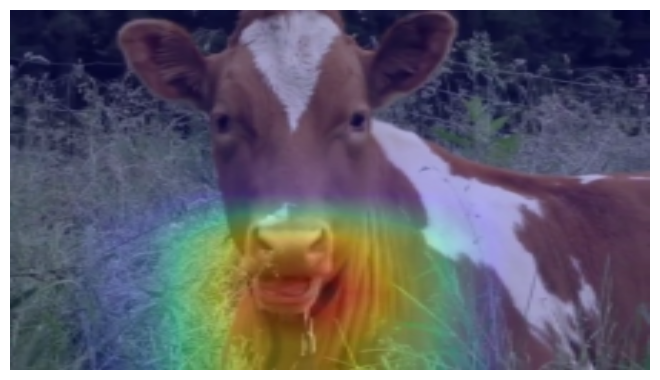

In [42]:
model = load_resnet152(CHECKPOINT_PATH)
print("ResNet-152 model loaded successfully from the checkpoint.")

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjusted size for ResNet input
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Load your dataset and DataLoader
batch_size = 32
root_dir = '../../data/BiteCount'
folds_dir = './'  # Directory containing fold CSVs
train_annotation_file = os.path.join(folds_dir, 'test_fold_10.csv')  # Replace with desired fold
train_dataset = MultitaskDataset(root_dir=root_dir, 
                                  annotation_file=train_annotation_file,
                                  transform=val_transforms,  # No transformation needed here
                                  rgb=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Iterate through the DataLoader to get an image tensor
data_iter = iter(train_loader)
batch = next(data_iter)
image_tensor = batch['rgb']  # Assuming 'rgb' is the key in the dataset
labels = batch['label']  # Assuming 'label' is the key for labels

# Select the first image tensor for demonstration
image_tensor = image_tensor[0].unsqueeze(0)  # Add batch dimension

# Generate the CAM for the image (you need to implement this function)
cam = generate_cam(model, normalize(image_tensor))

# Convert the image tensor to a numpy array for visualization
image_numpy = image_tensor[0].cpu().detach().numpy()  # Get the first image and detach from the graph

# Overlay the CAM on the original image
cam_overlay = cv2.resize(overlay_cam_on_image(image_numpy, cam), (640, 360))

# Display the CAM overlay without borders
plt.figure(figsize=(640/100, 360/100), dpi=100)  # Set figure size and DPI for high quality
plt.imshow(cam_overlay)
plt.axis('off')  # Turn off the axis
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove all margins

# Save the image in high quality
plt.savefig('cam_overlay.png', bbox_inches='tight', pad_inches=0, dpi=300)  # Save as PNG with high DPI

# Show the overlay
plt.show()